In [1]:
import tensorflow as tf
from core.model import ModelMNIST10x10_base

class Implement(ModelMNIST10x10_base):
    def __init__(self, batch_size=128, opt=tf.train.MomentumOptimizer(1.0, 0.9, use_nesterov=True)):
        super(Implement, self).__init__(batch_size, opt)

    def compute_gradient(self, cost, var_refs):
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        
        for l, g, v in zip(range(len(grads)), grads, var_refs):
            delta = g
            tf.summary.histogram('{}'.format(v.name.replace(':', '_')), v)
            tf.summary.histogram('{}/gradient'.format(v.name.replace(':', '_')), g)
            tf.summary.histogram('{}/delta'.format(v.name.replace(':', '_')), delta)
            
        return grads

In [2]:
import sys
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s', stream=sys.stdout)

model = Implement(batch_size=128*100)

[1129 11:55:24 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[1129 11:55:24 @prefetch.py:169] [PrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.


In [3]:
from core.utils import loop

%env CUDA_VISIBLE_DEVICES=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
history = loop(sess, model, 30, './summary/5_2_first_order_optimization_batch_128x100')

env: CUDA_VISIBLE_DEVICES=0
[INFO] session initialized
[INFO] [0000] [train] cost:0.571 accuracy:0.099 elapsed:2.924sec [valid] cost:0.371 accuracy:0.103 elapsed:0.088sec
[INFO] [0001] [train] cost:0.350 accuracy:0.114 elapsed:0.072sec [valid] cost:0.326 accuracy:0.113 elapsed:0.015sec
[INFO] [0002] [train] cost:0.326 accuracy:0.106 elapsed:0.110sec [valid] cost:0.325 accuracy:0.111 elapsed:0.006sec
[INFO] [0003] [train] cost:0.325 accuracy:0.111 elapsed:0.115sec [valid] cost:0.325 accuracy:0.113 elapsed:0.047sec
[INFO] [0004] [train] cost:0.325 accuracy:0.115 elapsed:0.105sec [valid] cost:0.325 accuracy:0.113 elapsed:0.006sec
[INFO] [0005] [train] cost:0.325 accuracy:0.111 elapsed:0.095sec [valid] cost:0.325 accuracy:0.114 elapsed:0.006sec
[INFO] [0006] [train] cost:0.324 accuracy:0.126 elapsed:0.072sec [valid] cost:0.324 accuracy:0.115 elapsed:0.006sec
[INFO] [0007] [train] cost:0.324 accuracy:0.115 elapsed:0.072sec [valid] cost:0.323 accuracy:0.114 elapsed:0.006sec
[INFO] [0008] [tr

average elapsed time train:0.077910sec valid:0.007115sec


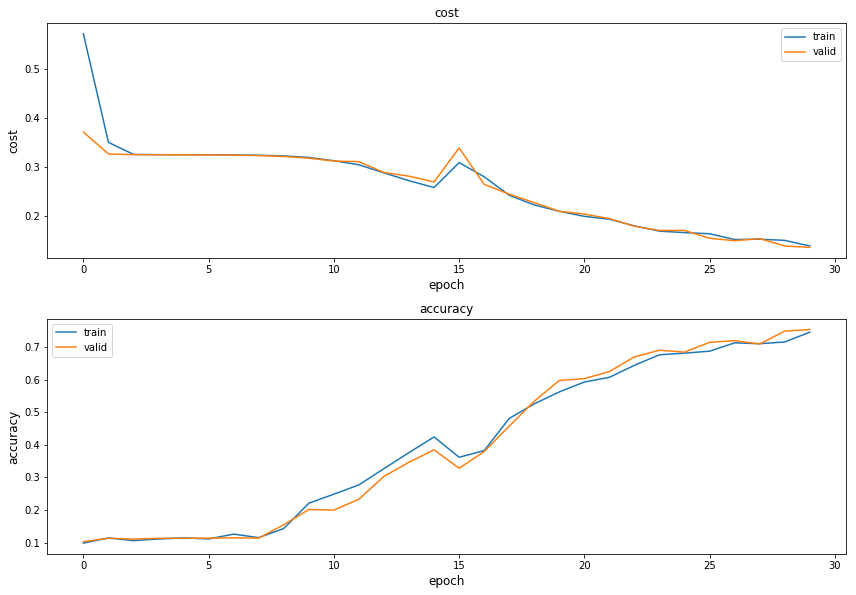

In [4]:
import matplotlib
%matplotlib inline

from core.utils import plot_jupyter
plot_jupyter(history)